# Przygotowanie środowiska
Import wymaganych bibliotek

In [2]:
import datetime
import os
import json


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

import seaborn as sns
from sklearn.metrics import ndcg_score

from keras.initializers import RandomNormal
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import (
    Concatenate,
    Dense,
    Embedding,
    Flatten,
    Input,
    Multiply,
)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

import optuna

2025-01-24 19:32:48.233289: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/home/david/anaconda3/envs/ML39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Import własnych funkcji

In [29]:
from utils import *
from model_architectures.MF import *
from model_architectures.NeuMF import *
from model_architectures.NeuMF_advanced import *

## Dane

Dane zostały wstępnie obrobione, i zapisane w folderze `datasets`  
- Informacje dotyczące wstępnej obróbki datasetu znajdują się w pliku `./datasets/parse_datasets.ipynb`
- Informacje dotyczące sposobu załadowania danych znajdują się w pliku `./utils.py`

**Wczytanie danych**
- treningowych
- testowych
- listy urzytkowników
- listy itemów

In [33]:
train_data, test_data, users_all, items_all = load_dataset(dataset_path="./datasets/ml-latest-small")

for (label, data) in [["train_data",train_data],["test_data",test_data]]:
  print(f"{label}:")
  display(data)

train_dataset = to_dataset(train_data, batch_size=2048*5)

train_data:


,interaction,item_id,user_id
0,0,5481,447
1,1,3672,88
2,0,8711,211
3,0,8603,274
4,0,3819,602
...,...,...,...
1108570,1,1598,297
1108571,0,756,452
1108572,0,3852,90
1108573,0,5523,481


test_data:


,interaction,item_id,user_id
0,0,3051,380
1,0,5238,280
2,0,2308,199
3,0,5303,542
4,0,4682,607
...,...,...,...
61605,0,2495,523
61606,0,9235,487
61607,0,255,67
61608,0,1831,435


# MF

## Model
Wczytanie modelu z pliku:

In [ ]:
with open("./model_architectures/MF_hiper_params.json", "r") as json_file:
  hiper_params = json_file.read()
  
hiper_params = json.loads(hiper_params)

hiper_params["n_users"] = len(users_all)
hiper_params["n_items"] = len(items_all)
model = create_model_MF(hiper_params)

## Trening
Callback urzywane w trakcie szkolenia:
- `TensorBoard` - włączenie obsługi TensorBoarda
- `EarlyStoppingAtNDGC` - własny callback zatrzymujący szkolenie kiedy `NDGC@10` modelu przez `patience` epok nie rośnie

`make_metrics_vs_epochs_graphs()` - na koniec treningu wyświetla statystyki metryk względem epok

**Kompilacja modelu i trening:**

# NeuMF

## Model
Wczytanie modelu z pliku:

In [15]:
with open("./model_architectures/NeuMF_hiper_params.json", "r") as json_file:
  hiper_params = json_file.read()
  
hiper_params = json.loads(hiper_params)

hiper_params["n_users"] = len(users_all)
hiper_params["n_items"] = len(items_all)
model = create_model_NeuMF(hiper_params)

## Trening
Callback urzywane w trakcie szkolenia:
- `TensorBoard` - włączenie obsługi TensorBoarda
- `EarlyStoppingAtNDGC` - własny callback zatrzymujący szkolenie kiedy `NDGC@10` modelu przez `patience` epok nie rośnie

`make_metrics_vs_epochs_graphs()` - na koniec treningu wyświetla statystyki metryk względem epok

**Kompilacja modelu i trening:**

In [16]:
model.compile(
  optimizer="adam",
  loss="binary_crossentropy",
  metrics=[
    tf.keras.metrics.BinaryAccuracy(name="accuracy"),
    tf.keras.metrics.AUC(name="auc"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
    tf.keras.metrics.TruePositives(name="tp"),
    tf.keras.metrics.FalsePositives(name="fp"),
    tf.keras.metrics.TrueNegatives(name="tn"),
    tf.keras.metrics.FalseNegatives(name="fn"),
  ],
)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
earlyStoppingAtNDGC = EarlyStoppingAtNDGC(patience=1, test_data=test_data)

train_hist = model.fit(
  train_dataset,
  epochs=200,
  callbacks=[tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1), earlyStoppingAtNDGC],
  verbose=1
) 
  
model.save("./models/NeuMF-ml-small.keras")

2025-01-24 19:38:42.525516: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-24 19:38:42.525576: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-24 19:38:42.525660: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2025-01-24 19:38:42.525678: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


Epoch 1/200
 2/91 [..............................] - ETA: 8s - loss: 2.1014 - accuracy: 0.6844 - auc: 0.4978 - precision: 0.0892 - recall: 0.2654 - tp: 398.0000 - fp: 4065.5000 - tn: 12670.5000 - fn: 1298.0000

2025-01-24 19:38:44.519397: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-24 19:38:44.519429: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-24 19:38:44.519491: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED


 5/91 [>.............................] - ETA: 13s - loss: 2.0664 - accuracy: 0.7728 - auc: 0.5003 - precision: 0.0892 - recall: 0.1623 - tp: 398.0000 - fp: 4065.8000 - tn: 29455.8000 - fn: 2944.4000WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0435s vs `on_train_batch_end` time: 0.0748s). Check your callbacks.


2025-01-24 19:38:44.683438: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2025-01-24 19:38:44.721509: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2025-01-24 19:38:44.740055: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2025-01-24 19:38:44.834170: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20250124-193842/train/plugins/profile/2025_01_24_19_38_44
2025-01-24 19:38:44.887659: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/20250124-193842/train/plugins/profile/2025_01_24_19_38_44/computer.trace.json.gz
2025-01-24 19:38:44.942238: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20250124-193842/train/plugins/profile/2025_01_24_19_38_44
2025-01-24 19:38:44.946089: I tensorflow/core/pro

91/91 [==============================] - 6s 47ms/step - loss: 1.3765 - accuracy: 0.8929 - auc: 0.5757 - precision: 0.0892 - recall: 0.0198 - tp: 398.0000 - fp: 4065.9891 - tn: 515278.2500 - fn: 51306.7826
Epoch 2/200
91/91 [==============================] - 4s 41ms/step - loss: 0.3955 - accuracy: 0.9096 - auc: 0.8529 - precision: 0.1011 - recall: 0.0027 - tp: 258.8261 - fp: 109.0000 - tn: 519235.8696 - fn: 51445.3261
Epoch 3/200
91/91 [==============================] - 4s 42ms/step - loss: 0.3068 - accuracy: 0.9230 - auc: 0.8737 - precision: 0.6768 - recall: 0.2867 - tp: 14964.9891 - fp: 7076.3696 - tn: 512269.3804 - fn: 36738.2826
Epoch 4/200
91/91 [==============================] - 4s 42ms/step - loss: 0.2712 - accuracy: 0.9269 - auc: 0.8927 - precision: 0.7096 - recall: 0.3260 - tp: 16997.8261 - fp: 6851.3261 - tn: 512493.2826 - fn: 34706.5870
Epoch 5/200
91/91 [==============================] - 4s 42ms/step - loss: 0.2495 - accuracy: 0.9293 - auc: 0.9096 - precision: 0.7136 - recal

## Ewaluacja modelu

### Metryki na przestrzeni epok

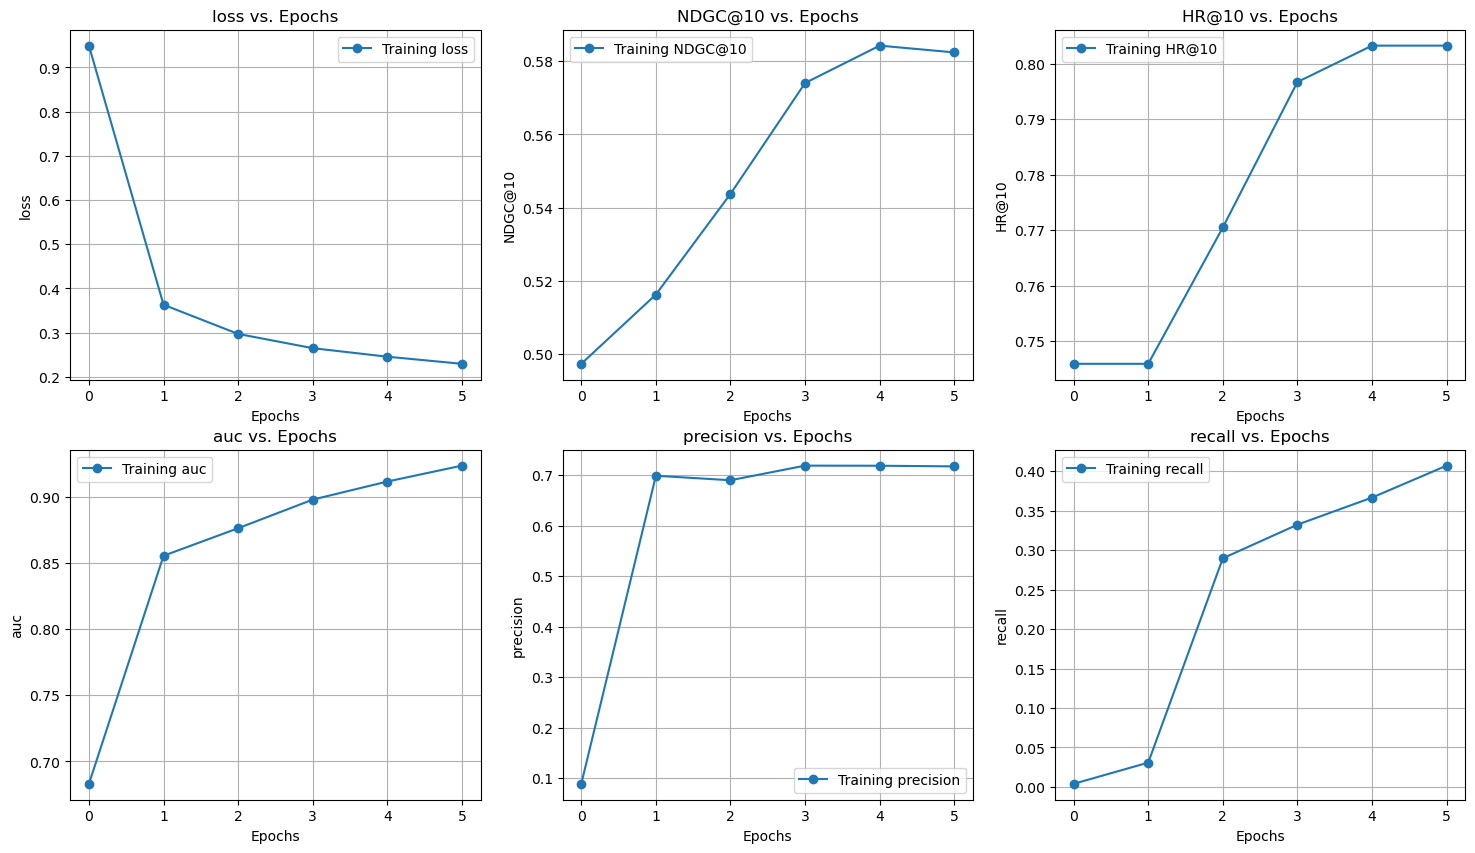

In [17]:
make_metrics_vs_epochs_graphs(train_hist, earlyStoppingAtNDGC)

### Ewaluacja metodą *leave-one-out*

#### Metoda *leave-one-out*
Standard w ewaluacji systemów rekomendacji, polega na stworzenie datasetu testowego poprzez (dla każdego urzytkownika):
- usuwamy ostatnią interakcję z datasetu treningowego i przerzucamy do datasetu testowego
- dodajemy do datasetu testowego 100 itemów z którymi nie zaistniała interakcja

Najpopularniejszymi metrykami w tej metodzie są:
- `HR@K` (Hit Rate at K) - określa w ilu procentach przypadków system przewidział prawdziwą interakcję w K najprawdopodomniejszych predykcjach
- `NDGC@K` (Normalized Discounted Cumulative Gain at K) - wskazuje jak wysoko w K najprawdopodobniejszych predykcjach znajduje się prawdziwa interakcja (1 dla prawdziwej interakcji zawsze na pierwszym miejscu)

#### Ewaluacja

NDGC@10: 0.5824411471808246
HR@10: 0.8032786885245902


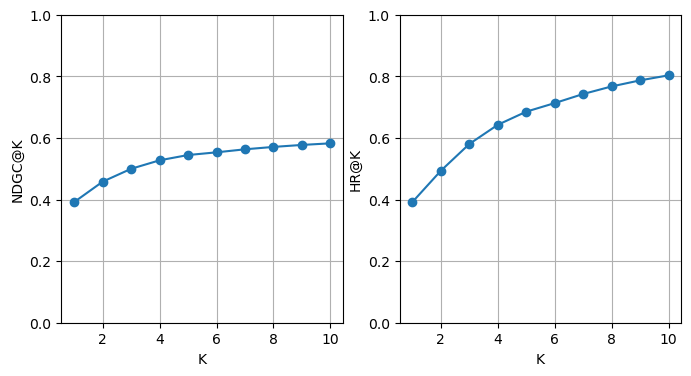

In [ ]:
predictions = model.predict([test_data["user_id"].values, test_data["item_id"].values], batch_size=1024*8, verbose=0)
test_data["predictions"] = predictions

td2 = test_data.groupby(['user_id', 'item_id', 'predictions'], as_index=False)['interaction'].max()
y_score = td2.pivot(index='user_id', columns='item_id', values='predictions').fillna(0).values
valid_true = td2[['user_id', 'item_id', 'interaction']].pivot(index='user_id', columns='item_id', values='interaction').fillna(0).values

ndcg_at_k = ndcg_score(valid_true, y_score, k=10)
hr_at_k = calculate_hr_at_k(test_data, k=10)
print(f"NDGC@10: {ndcg_at_k}")
print(f"HR@10: {hr_at_k}")

make_metrics_vs_k_graphs(test_data)



|  | Mój NeuMF | Orginalne NeuMF       | Orginalne NeuMF z pretreningiem       |
|-----------------|----------------|----------------|----------------|
| HR@10 | 0.803 | 0.705 | 0.730 |
| NDGC@10 | 0.582 | 0.426 | 0.447 |

\* Orginalne modele były trenowane na pełnym datasecie, przy stałej ilości `latent_dim` równej 64 (najleprze zaraportowane wyniki przez autorów)

# NeuMF_advanced

## Model
Wczytanie modelu z pliku:

In [52]:
with open("./model_architectures/NeuMF_advanced_hiper_params.json", "r") as json_file:
  hiper_params = json_file.read()
  
hiper_params = json.loads(hiper_params)

hiper_params["n_users"] = len(users_all)
hiper_params["n_items"] = len(items_all)
model = create_model_NeuMF_advanced(hiper_params)

## Trening
Callback urzywane w trakcie szkolenia:
- `TensorBoard` - włączenie obsługi TensorBoarda
- `EarlyStoppingAtNDGC` - własny callback zatrzymujący szkolenie kiedy `NDGC@10` modelu przez `patience` epok nie rośnie

`make_metrics_vs_epochs_graphs()` - na koniec treningu wyświetla statystyki metryk względem epok

**Kompilacja modelu i trening:**

In [53]:
model.compile(
  optimizer="adam",
  loss="binary_crossentropy",
  metrics=[
    tf.keras.metrics.BinaryAccuracy(name="accuracy"),
    tf.keras.metrics.AUC(name="auc"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
    tf.keras.metrics.TruePositives(name="tp"),
    tf.keras.metrics.FalsePositives(name="fp"),
    tf.keras.metrics.TrueNegatives(name="tn"),
    tf.keras.metrics.FalseNegatives(name="fn"),
  ],
)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
earlyStoppingAtNDGC = EarlyStoppingAtNDGC(patience=10, test_data=test_data)

train_hist = model.fit(
  train_dataset,
  epochs=5,
  callbacks=[tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1), earlyStoppingAtNDGC],
  verbose=1
) 
  
model.save("./models/NeuMF_advanced-ml-small.keras")

2025-01-24 20:04:42.986509: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-24 20:04:42.986545: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-24 20:04:42.986596: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2025-01-24 20:04:42.986613: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


Epoch 1/5
  2/109 [..............................] - ETA: 9s - loss: 9.2843 - accuracy: 0.2958 - auc: 0.5000 - precision: 0.0916 - recall: 0.7458 - tp: 937.0000 - fp: 9292.0000 - tn: 4648.0000 - fn: 483.0000

2025-01-24 20:04:44.836056: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-24 20:04:44.836085: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-24 20:04:44.836129: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2025-01-24 20:04:44.991712: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.


  7/109 [>.............................] - ETA: 10s - loss: 8.9537 - accuracy: 0.6067 - auc: 0.5024 - precision: 0.0916 - recall: 0.3704 - tp: 937.0000 - fp: 9292.0000 - tn: 27952.4286 - fn: 2778.5714

2025-01-24 20:04:45.025865: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2025-01-24 20:04:45.045995: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2025-01-24 20:04:45.120198: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20250124-200442/train/plugins/profile/2025_01_24_20_04_45
2025-01-24 20:04:45.164459: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/20250124-200442/train/plugins/profile/2025_01_24_20_04_45/computer.trace.json.gz
2025-01-24 20:04:45.212735: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20250124-200442/train/plugins/profile/2025_01_24_20_04_45
2025-01-24 20:04:45.216650: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to logs/20250124-200442/tra

109/109 [==============================] - 6s 37ms/step - loss: 5.0314 - accuracy: 0.8703 - auc: 0.5345 - precision: 0.0916 - recall: 0.0483 - tp: 937.0000 - fp: 9292.0000 - tn: 507359.3000 - fn: 50500.7000
Epoch 2/5
109/109 [==============================] - 4s 33ms/step - loss: 0.3753 - accuracy: 0.9096 - auc: 0.8531 - precision: 0.0903 - recall: 0.0021 - tp: 204.9273 - fp: 84.3364 - tn: 516568.0364 - fn: 51231.7000
Epoch 3/5
109/109 [==============================] - 4s 36ms/step - loss: 0.2172 - accuracy: 0.9240 - auc: 0.8959 - precision: 0.6873 - recall: 0.2948 - tp: 15280.3818 - fp: 6752.6727 - tn: 509899.1727 - fn: 36156.7727
Epoch 4/5
109/109 [==============================] - 4s 36ms/step - loss: 0.1879 - accuracy: 0.9278 - auc: 0.9270 - precision: 0.7301 - recall: 0.3218 - tp: 16626.5091 - fp: 6074.6091 - tn: 510577.4091 - fn: 34810.4727
Epoch 5/5
109/109 [==============================] - 4s 38ms/step - loss: 0.1728 - accuracy: 0.9293 - auc: 0.9429 - precision: 0.7083 - reca

## Ewaluacja modelu

### Metryki na przestrzeni epok

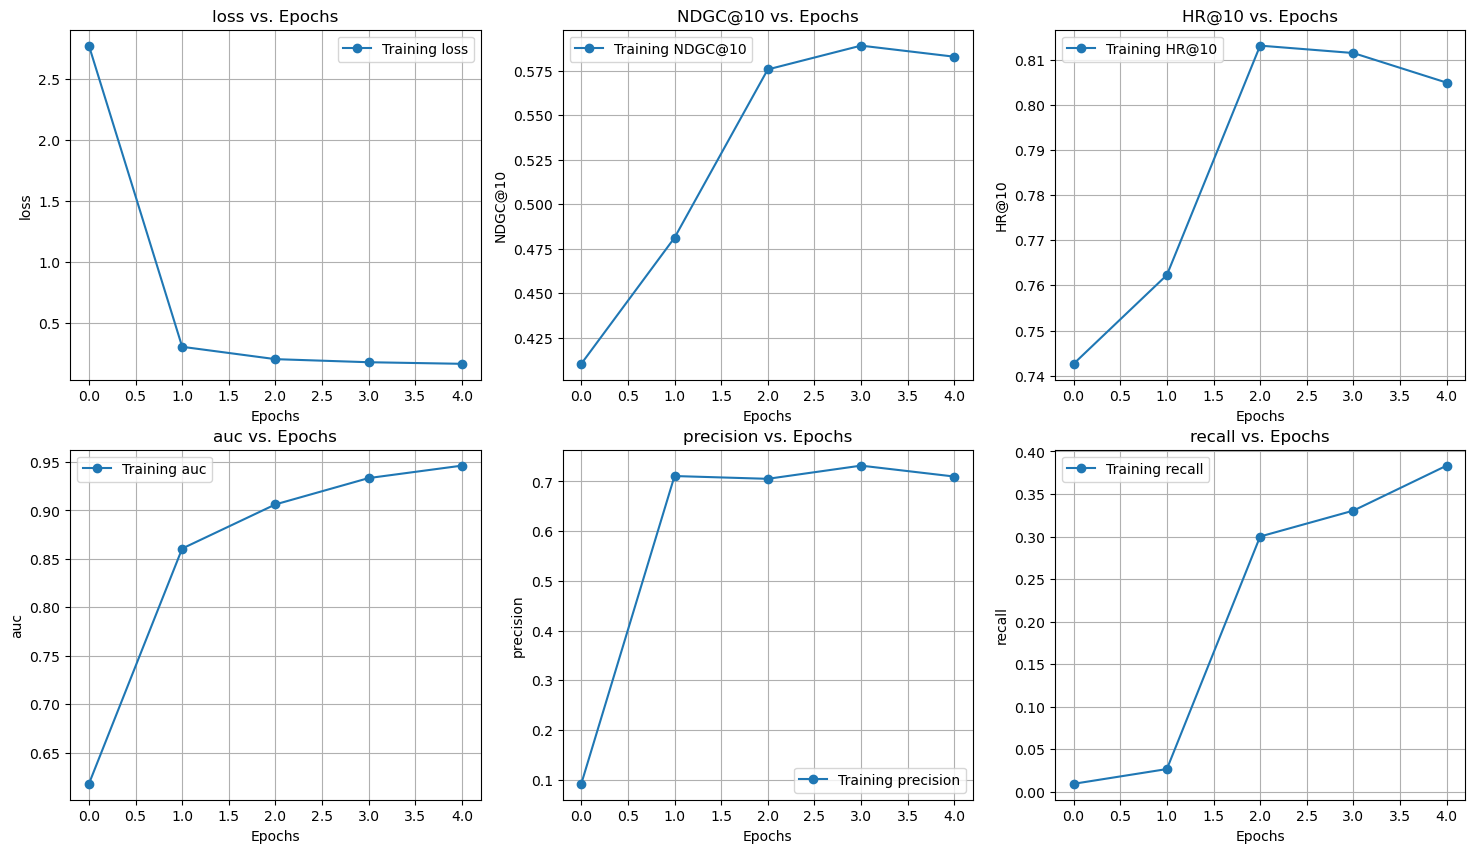

In [54]:
make_metrics_vs_epochs_graphs(train_hist, earlyStoppingAtNDGC)

### Ewaluacja metodą *leave-one-out*
#### Metoda *leave-one-out*
Standard w ewaluacji systemów rekomendacji, polega na stworzenie datasetu testowego poprzez (dla każdego urzytkownika):
- usuwamy ostatnią interakcję z datasetu treningowego i przerzucamy do datasetu testowego
- dodajemy do datasetu testowego 100 itemów z którymi nie zaistniała interakcja

Najpopularniejszymi metrykami w tej metodzie są:
- `HR@K` (Hit Rate at K) - określa w ilu procentach przypadków system przewidział prawdziwą interakcję w K najprawdopodomniejszych predykcjach
- `NDGC@K` (Normalized Discounted Cumulative Gain at K) - wskazuje jak wysoko w K najprawdopodobniejszych predykcjach znajduje się prawdziwa interakcja (1 dla prawdziwej interakcji zawsze na pierwszym miejscu)
#### Ewaluacja

NDGC@10: 0.5829677496150912
HR@10: 0.8049180327868852


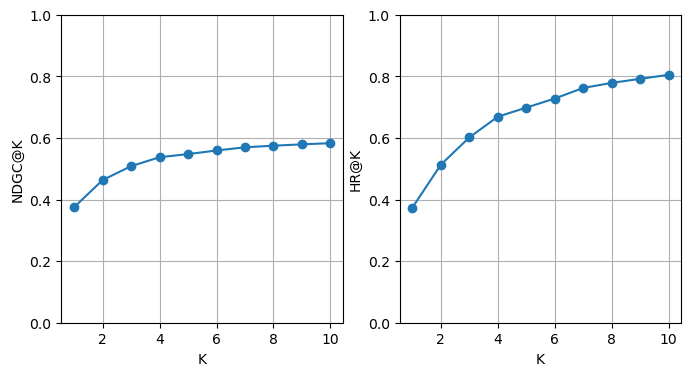

In [55]:
predictions = model.predict([test_data["user_id"].values, test_data["item_id"].values], batch_size=1024*8, verbose=0)
test_data["predictions"] = predictions

td2 = test_data.groupby(['user_id', 'item_id', 'predictions'], as_index=False)['interaction'].max()
y_score = td2.pivot(index='user_id', columns='item_id', values='predictions').fillna(0).values
valid_true = td2[['user_id', 'item_id', 'interaction']].pivot(index='user_id', columns='item_id', values='interaction').fillna(0).values

ndcg_at_k = ndcg_score(valid_true, y_score, k=10)
hr_at_k = calculate_hr_at_k(test_data, k=10)
print(f"NDGC@10: {ndcg_at_k}")
print(f"HR@10: {hr_at_k}")

make_metrics_vs_k_graphs(test_data)


|  | Mój NeuMF | Orginalne NeuMF       | Orginalne NeuMF z pretreningiem       |
|-----------------|----------------|----------------|----------------|
| HR@10 | 0.805 | 0.705 | 0.730 |
| NDGC@10 | 0.583 | 0.426 | 0.447 |

\* Orginalne modele były trenowane na pełnym datasecie, przy stałej ilości `latent_dim` równej 64 (najleprze zaraportowane wyniki przez autorów)